In [1]:
import glob
import gzip
import json
from natsort import natsorted
import os
import shutil

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pysam
import seaborn as sns
import tensorflow as tf

import pygene
from basenji import dna_io
from basenji import metrics
from basenji import trainer

2022-07-09 11:39:34.102280: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/drk/code/torch_1-2018/install/lib:/usr/local/cuda-11.2/targets/x86_64-linux/lib:
2022-07-09 11:39:34.102336: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
np.random.seed(44)

## Precursors

In [3]:
# human
stability_file = '~vagar/RNAbinding/forPaper/Fig4/binnedgenes.txt'
vikram_gtf_file = '/home/vagar/RNAbinding/forPaper/datasets/human/Homo_sapiens.GRCh38.83.chosenTranscript.gtf'
# human_gtf_file = '/home/vagar/RNAbinding/forPaper/datasets/human/Homo_sapiens.GRCh38.83.chosenTranscript.gtf'
genome_fasta_file = '%s/assembly/ensembl/Homo_sapiens.GRCh38.dna.primary_assembly.fa' % os.environ['HG38']

In [4]:
# # mouse
# stability_file = 'mouse_stability.tsv'
# vikram_gtf_file = '/home/vagar/RNAbinding/forPaper/datasets/mouse/Mus_musculus.GRCm3.90.chosenTranscript.gtf.gz'
# genome_fasta_file = '%s/assembly/ensembl/Mus_musculus.GRCm38.dna.primary_assembly.fa' % os.environ['MM10']

In [5]:
def trim_dot(gene_id):
    dot_i = gene_id.find('.')
    if dot_i != -1:
        gene_id = gene_id[:dot_i]
    return gene_id

In [6]:
def read_gene_fasta(fasta_file, trim_geneid=False):
    if fasta_file[-3:] == '.gz':
        fasta_open = gzip.open(fasta_file, 'rt')
    else:
        fasta_open = open(fasta_file, 'r')
        
    gene_seq = {}
    for line in fasta_open:
        if line[0] == '>':
            gene = line[1:].rstrip()
            if trim_geneid:
                gene = trim_dot(gene)
            gene_seq[gene] = ''
        else:
            gene_seq[gene] += line.rstrip()
            
    fasta_open.close()
        
    return gene_seq

In [7]:
def rna_1hot_splice(transcript, genome_open):
    """Extract RNA nucleotides and add splice and coding frame channels.
        Consider strand, but do not yet reverse complement, because its
        easier to handle variant substitution."""

    # exons RNA
    tx_exons = transcript.fasta_exons(genome_open, stranded=False)
    seq_len = len(tx_exons)

    # CDS RNA
    tx_cds = transcript.fasta_cds(genome_open, stranded=False)
    if len(tx_cds) % 3 == 0:
        valid_coding = True
    else:
        # print('WARNING: %d mod 3 == %d length:' % (len(tx_cds),len(tx_cds)%3), transcript)
        valid_coding = False
    cds_start = tx_exons.find(tx_cds)
    if cds_start == -1:
        print(transcript)
    cds_end = cds_start + len(tx_cds)

    # add frame channel
    frame_channel = np.zeros((seq_len,1))
    if valid_coding:
        aa_len = (cds_end - cds_start) // 3
        if transcript.strand == '+':
            frame_channel[cds_start:cds_end,0] = np.tile([1,0,0], aa_len)
        else:
            frame_channel[cds_start:cds_end,0] = np.tile([0,0,1], aa_len)

    # splice track
    splice_channel = np.zeros((seq_len,1))
    ti = 0
    exon_lens = [ex.end-ex.start for ex in transcript.exons]
    for el in exon_lens:
        if transcript.strand == '+':
            ti += el
            splice_channel[ti-1,0] = 1
        else:
            splice_channel[ti,0] = 1
            ti += el

    # 1 hot encode
    tx_seq1 = dna_io.dna_1hot(tx_exons, n_sample=True)
    tx_seq1 = np.concatenate([tx_seq1, frame_channel, splice_channel], axis=-1)
    
    # reverse complement
    if transcript.strand == '-':
        tx_seq1 = dna_io.hot1_rc(tx_seq1)

    return tx_seq1

In [8]:
def set_rna_length(tx_seq1, length):
    """Set RNA length to specific value by padding or trimming."""
    seq_len, seq_depth = tx_seq1.shape

    if seq_len < length:
        # pad
        pad_len = length - seq_len
        pad_seq1 = np.zeros((pad_len,seq_depth))
        tx_seq1 = np.concatenate([tx_seq1,pad_seq1], axis=0)

    elif seq_len > length:
        # trim 5'
        tx_seq1 = tx_seq1[-length:]

    return tx_seq1

## Read stability measurements

In [ ]:
# read sample table
stability_df = pd.read_csv(stability_file, sep='\t')
stability_df.columns = ['Fold','Gene','Stability']
stability_df

In [10]:
genes_gtf_file = 'genes.gtf'
genes_gtf_out = open(genes_gtf_file, 'w')
    
for line in open(vikram_gtf_file):
    a = line.rstrip().split('\t')
    tx_id, gene_id = a[-1].split(':')
    a[-1] = 'gene_id "%s"; transcript_id "%s"; saluki_score "1.0";' % (gene_id, tx_id)
    print('\t'.join(a), file=genes_gtf_out)
        
genes_gtf_out.close()

In [12]:
########################################################
# read gene data

# open genes GTF
genes_gtf = pygene.GTF(genes_gtf_file)

# open genome FASTA
genome_open = pysam.Fastafile(genome_fasta_file)

# initialize dicts
gene_seq1 = {}
# gene_names = {}

for gene_id, gene in genes_gtf.genes.items():
    # choose top transcript
    score_transcripts = [(tx.kv['saluki_score'],tx_id,tx) for tx_id, tx in gene.transcripts.items()]
    _, tx_id, tx = sorted(score_transcripts)[-1]
    
    # one hot encode
    tx_seq1 = rna_1hot_splice(tx, genome_open)
    
    # check coding
    valid_coding = (tx_seq1[:,-2].sum() > 0)
    
    # save
    if valid_coding:
        gene_id = trim_dot(gene_id)
        gene_seq1[gene_id] = tx_seq1
        # gene_names[gene_id] = tx.kv['gene_name']

1 + gene_id "ENSG00000122484"; transcript_id "ENST00000610020"; saluki_score "1.0";  [92298965-92299146],[92300194-92300239],[92301476-92301590],[92303977-92304075],[92304284-92304349],[92307188-92307276],[92320599-92320634],[92323445-92324375],[92333391-92333473],[92336347-92336427],[92345846-92345914],[92380724-92380873],[92387011-92402056]
3 + gene_id "ENSG00000168314"; transcript_id "ENST00000311042"; saluki_score "1.0";  [39467680-39467740],[39480040-39480123],[39502066-39502275],[39502463-39502876],[39513383-39516001]
3 + gene_id "ENSG00000185008"; transcript_id "ENST00000332191"; saluki_score "1.0";  [77040730-77040846],[77098014-77098340],[77477414-77477571],[77481099-77481219],[77493244-77493382],[77522775-77522902],[77546338-77546462],[77550818-77550989],[77557944-77558149],[77562651-77562732],[77563167-77563329],[77564954-77565120],[77568313-77568434],[77574499-77574730],[77577490-77577614],[77579947-77580118],[77588751-77588933],[77595142-77595184],[77596623-77596750],[7760

In [13]:
# filter genes

gene_mask = np.array([gene_id in gene_seq1 for gene_id in stability_df.Gene])
gene_mask.sum(), gene_mask.mean()

(12968, 0.9989985363223173)

In [14]:
print(stability_df[~gene_mask])

       Fold             Gene  Stability
522       2  ENSG00000048405  -1.724673
2855      7  ENSG00000108424   0.868830
4208      6  ENSG00000122484  -0.680720
4238      6  ENSG00000122756   1.396266
4243      1  ENSG00000122824  -0.200585
8796      2  ENSG00000165480  -0.280310
10178     2  ENSG00000174963  -0.002990
10234     6  ENSG00000175445   0.429118
11161     2  ENSG00000185008  -0.219503
11333    10  ENSG00000186352  -1.703123
11675     8  ENSG00000196368   0.057440
11725     6  ENSG00000196605   0.607139
12177     3  ENSG00000203791   0.883445


In [15]:
# filter genes

stability_df = stability_df[gene_mask].copy()
stability_df.shape

(12968, 3)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


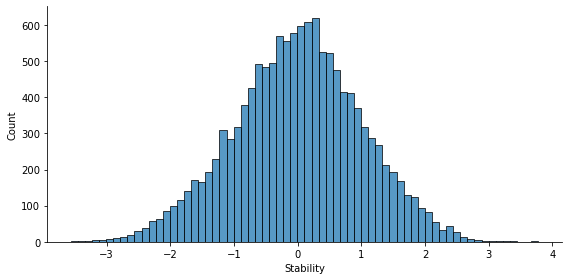

In [16]:
sns.displot(stability_df.Stability, aspect=2, height=4)

## Length

In [17]:
# add length

gene_lengths = np.array([gene_seq1[gene_id].shape[0] for gene_id in stability_df.Gene])
stability_df['Length'] = gene_lengths

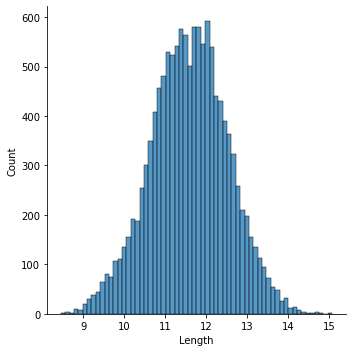

In [18]:
sns.displot(np.log2(1+stability_df.Length))

In [19]:
full_len_t = 2**14
full_len_t, np.log2(full_len_t), (stability_df.Length<full_len_t).mean()

(16384, 14.0, 0.9966070326958667)

In [20]:
full_len_t = 3*2**12
full_len_t, np.log2(full_len_t), (stability_df.Length<full_len_t).mean()

(12288, 13.584962500721156, 0.9844231955582974)

## Training data

In [21]:
# set fold masks

num_folds = len(set(stability_df.Fold))
fold_masks = []
for fi in range(num_folds):
    fold_indexes = np.where(stability_df.Fold == fi+1)[0]
    fold_mask = np.zeros(stability_df.shape[0], dtype='bool')
    fold_mask[fold_indexes] = 1
    fold_masks.append(fold_mask)

In [22]:
def feature_bytes(values):
    """Convert numpy arrays to bytes features."""
    values = values.flatten().tostring()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[values]))

In [23]:
def tfr_feature_ints(int_list):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=int_list))
def tfr_feature_dna(seq_1hot):
    seq_indexes = np.where(seq_1hot)[1].astype('uint8')
    seq_indexes = seq_indexes.tostring()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[seq_indexes]))
def tfr_feature_track(seq_track):
    seq_track = seq_track.astype('uint8')
    seq_track = seq_track.tostring()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[seq_track]))
def tfr_feature_targets(targets):
    targets = targets.astype('float16')
    targets = targets.tostring()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[targets]))

In [24]:
def write_fold(fold_index, out_dir, seqs_per_tfr=128):
    tf_opts = tf.io.TFRecordOptions(compression_type='ZLIB')
    
    # slice fold's genes
    fold_df = stability_df[fold_masks[fold_index]]
    
    gi = 0
    num_tfr = int(np.ceil(fold_df.shape[0] / seqs_per_tfr))
    for fi in range(num_tfr):
        tfr_file = '%s/fold%d-%d.tfr' % (out_dir,fold_index,fi)
        with tf.io.TFRecordWriter(tfr_file, tf_opts) as writer:
            for ti in range(seqs_per_tfr):
                if gi < fold_df.shape[0]:
                    sgene = fold_df.iloc[gi]
                    gene_id = sgene.Gene
                    
                    # trim sequence
                    seq1 = gene_seq1[gene_id][:full_len_t]
                    seq_len = seq1.shape[0]
                    
                    # split
                    sequence = seq1[:,:4]
                    coding = seq1[:,4]
                    splice = seq1[:,5]
                        
                    # targets
                    # targets = np.log2(sgene.Stability + pseudocount)
                    targets = sgene.Stability

                    # hash to bytes
                    features_dict = {
                        'lengths': tfr_feature_ints([seq_len]),
                        'sequence': tfr_feature_dna(sequence),
                        'coding': tfr_feature_track(coding),
                        'splice': tfr_feature_track(splice),
                        'targets': tfr_feature_targets(targets)
                    }

                    # write example
                    example = tf.train.Example(features=tf.train.Features(feature=features_dict))
                    writer.write(example.SerializeToString())
                
                    # next gene
                    gi += 1

In [25]:
################################################################
# output directory

out_dir = 'data'
if os.path.isdir(out_dir):
    shutil.rmtree(out_dir)
os.mkdir(out_dir)

################################################################
# stats
stats_dict = {}
stats_dict['num_targets'] = 1
stats_dict['target_length'] = 1
stats_dict['length_t'] = full_len_t

stats_dict['num_folds'] = num_folds
for fi in range(num_folds):
    stats_dict['fold%d_seqs' % fi] = int(fold_masks[fi].sum())

with open('%s/statistics.json' % out_dir, 'w') as stats_json_out:
    json.dump(stats_dict, stats_json_out, indent=4)
    
################################################################
# write gene table

data_genes_df_list = [] 
for fi in range(num_folds):
    fold_df = stability_df[fold_masks[fi]]    
    data_genes_df_list.append(fold_df)

data_genes_df = pd.concat(data_genes_df_list, axis=0)
data_genes_df.set_index(np.arange(data_genes_df.shape[0]), inplace=True)
data_genes_df['Fold'] = data_genes_df.Fold - 1
data_genes_df.to_csv('%s/genes.tsv' % out_dir, sep='\t')

################################################################
# write tfrecords

tfrecords_dir = '%s/tfrecords' % out_dir
os.mkdir(tfrecords_dir)
for fi in range(num_folds):
    write_fold(fi, tfrecords_dir)

/tmp/ipykernel_8716/1940088090.py:5: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  seq_indexes = seq_indexes.tostring()
/tmp/ipykernel_8716/1940088090.py:9: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  seq_track = seq_track.tostring()
/tmp/ipykernel_8716/1940088090.py:13: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  targets = targets.tostring()
